In [ ]:
!pip install lightning https://github.com/PyTorchLightning/pytorch-lightning/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     / 18.0 MB 659 kB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 191 kB 12.8 MB/s 
     |████████████████████████████████| 529 kB 70.3 MB/s 
     |████████████████████████████████| 107 kB 57.9 MB/s 
     |████████████████████████████████| 72 kB 1.1 MB/s 
     |████████████████████████████████| 66 kB 5.6 MB/s 
     |████████████████████████████████| 359 kB 75.5 MB/s 
     |████████████████████████████████| 87 kB 6.2 MB/s 
     |████████████████████████████████| 55 kB 4.5 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 237 kB 61.6 MB/s 
     |████████████████████████████████| 65 kB 4.3 MB/s 
     |████████████████████████████████| 9.1 MB 62.3 MB/s 
     |████████████████████████████████| 140 kB 73.6 MB/s 
     |███

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tokenizers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 12.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 10.5 MB/s 
     |████████████████████████████████| 163 kB 55.6 MB/s 


# Imports

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm


import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, seed_everything, Trainer, LightningModule
from torchmetrics.functional import accuracy, f1_score, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loops.base import Loop
from pytorch_lightning.loops.fit_loop import FitLoop
from pytorch_lightning.trainer.states import TrainerFn

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold


import re
import random
import scipy as sp

import tokenizers
import transformers 
from transformers import AutoTokenizer, AutoModel, AutoConfig

from transformers import get_linear_schedule_with_warmup, AdamW, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

from abc import ABC, abstractmethod
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Type

from copy import deepcopy

env: TOKENIZERS_PARALLELISM=true


# Directories

In [ ]:
INPUT_DIR = '/content/drive/Shareddrives/hlt_usppm/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Configuration Flags

In [ ]:
class CFG:
    num_workers=4
    #model="microsoft/deberta-v3-large"
    model="distilbert-base-uncased"
    warmup_steps=0
    epochs=4
    batch_size=256
    n_fold=4
    seed=42
    fc_dropout=0.2
    target_size=1

tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="USPPPM")

In [ ]:
pl.seed_everything(CFG.seed)

INFO:lightning_lite.utilities.seed:Global seed set to 42


42

In [ ]:
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


# Data Loading

In [ ]:
train_df = pd.read_csv(INPUT_DIR+'train.csv')
test_df = pd.read_csv(INPUT_DIR+'test.csv')
submission_df = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train_df.shape}")
print(f"test.shape: {test_df.shape}")
print(f"submission.shape: {submission_df.shape}")
display(train_df.head())
display(test_df.head())
display(submission_df.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


### CPC data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('/content/drive/Shareddrives/hlt_usppm/CPCSchemeXML202105/'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'/content/drive/Shareddrives/hlt_usppm/CPCTitleList202208/cpc-section-{cpc}_20220801.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train_df['context_text'] = train_df['context'].map(cpc_texts)
test_df['context_text'] = test_df['context'].map(cpc_texts)
display(train_df.head())
display(test_df.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [ ]:
train_df['text'] = train_df['anchor'] + '[SEP]' + train_df['target'] + '[SEP]'  + train_df['context_text']
test_df['text'] = test_df['anchor'] + '[SEP]' + test_df['target'] + '[SEP]'  + test_df['context_text']
display(train_df.head())
display(test_df.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# A bit of statistics

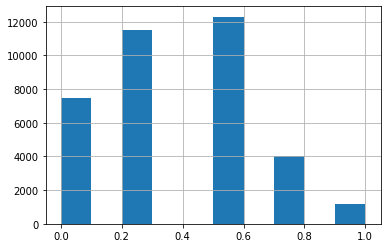

In [ ]:
train_df['score'].hist()

In [ ]:
display(train_df['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

# CV With lightning

## Dataset
First, we define the maximum length of the tokens concatenations.

In [ ]:
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train_df[text_col].fillna("").values, total=len(train_df))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
print(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 125


In [ ]:
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class USPPM_dataset(Dataset):
    def __init__(self, cfg, df, train):
        self.cfg = cfg
        self.texts = df['text'].values
        self.train = train
        if train:
            self.labels = df['score'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        if self.train:
            labels = torch.tensor(self.labels[item], dtype=torch.float)
            return dict(
                  inputs=inputs,
                  labels=labels
            )
        else:
            return dict(
                  inputs=inputs
            )

We wrap the dataset in a LightningDataModule.

**Step 1 / 5: Define KFold DataModule API**                       
Our KFold DataModule requires to implement the `setup_folds` and `setup_fold_index` methods.

In [ ]:
class BaseKFoldDataModule(LightningDataModule, ABC):
    @abstractmethod
    def setup_folds(self, num_folds: int) -> None:
        pass

    @abstractmethod
    def setup_fold_index(self, fold_index: int) -> None:
        pass

**Step 2 / 5: Implement the KFoldDataModule**
The `KFoldDataModule` will take a train and test dataset.                                
On `setup_folds`, folds will be created depending on the provided argument `num_folds`    
Our `setup_fold_index`, the provided train dataset will be split accordingly to
the current fold split.  

In [ ]:
@dataclass
class USPPPM_kf_datamodule(BaseKFoldDataModule):

    train_dataset: Optional[Dataset] = None
    test_dataset: Optional[Dataset] = None
    train_fold: Optional[Dataset] = None
    val_fold: Optional[Dataset] = None

    #def prepare_data(self) -> None:
        # download the data.
        #MNIST(_DATASETS_PATH, transform=T.Compose([T.ToTensor(), T.Normalize(mean=(0.5,), std=(0.5,))]))

    #def setup(self, stage: Optional[str] = None) -> None:
        # load the data
        # dataset = MNIST(_DATASETS_PATH, transform=T.Compose([T.ToTensor(), T.Normalize(mean=(0.5,), std=(0.5,))]))
        # self.train_dataset, self.test_dataset = random_split(dataset, [50000, 10000])

    def setup_folds(self, num_folds: int) -> None:
        self.num_folds = num_folds
        self.splits = [split for split in KFold(num_folds).split(range(len(self.train_dataset)))]

    def setup_fold_index(self, fold_index: int) -> None:
        train_indices, val_indices = self.splits[fold_index]
        self.train_fold = Subset(self.train_dataset, train_indices)
        self.val_fold = Subset(self.train_dataset, val_indices)
        print("TRAIN FOLD", fold_index + 1, len(self.train_fold))
        print("VALID FOLD", fold_index + 1, len(self.val_fold))

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_fold)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.val_fold)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test_dataset)

    def __post_init__(cls):
        super().__init__()

In [ ]:
train_dataset = USPPM_dataset(CFG, train_df, train=True)
datamodule = USPPPM_kf_datamodule(train_dataset)

**Step 3 / 5: Ensemble Model for kfold** The `EnsembleVotingModel` will take our custom LightningModule and several checkpoint_paths.   

In [ ]:
class EnsembleVotingModel(LightningModule):
    def __init__(self, model_cls: Type[LightningModule], checkpoint_paths: List[str]):
        super().__init__()
        # Create `num_folds` models with their associated fold weights
        print(checkpoint_paths)
        self.models = torch.nn.ModuleList([model_cls.load_from_checkpoint(p) for p in checkpoint_paths])
        self.last_acc = Accuracy()


    def test_step(self, batch: Any, batch_idx: int, dataloader_idx: int = 0) -> None:
        # Compute the averaged predictions over the `num_folds` models.
        logits = torch.stack([m(batch[0]) for m in self.models])

        avg_logits = logits.mean(0)
        acc = self.last_acc(avg_logits, batch[1])

        accs = torch.stack([self.last_acc(logit, batch[1]) for logit in logits])
        avg_acc = accs.mean(0)
        self.log('voting acc', acc)
        print('accs print', accs)
        print('avg_acc print', avg_acc)
        self.log('avg_acc', avg_acc)


**Step 4 / 5: Implement the  KFoldLoop**
From Lightning v1.5, it is possible to implement your own loop. There is several steps
to do so which are described in detail within the documentation
https://pytorch-lightning.readthedocs.io/en/latest/extensions/loops.html.
Here, we will implement an outer fit_loop. It means we will implement subclass the base Loop and wrap the current trainer `fit_loop`.  

In [ ]:
class KFoldLoop(Loop):
    def __init__(self, num_folds: int, export_path: str) -> None:
        super().__init__()
        self.num_folds = num_folds
        self.current_fold: int = 0
        self.export_path = export_path

    @property
    def done(self) -> bool:
        return self.current_fold >= self.num_folds

    def connect(self, fit_loop: FitLoop) -> None:
        self.fit_loop = fit_loop

    def reset(self) -> None:
        """Nothing to reset in this loop."""

    def on_run_start(self, *args: Any, **kwargs: Any) -> None:
        """Used to call `setup_folds` from the `BaseKFoldDataModule` instance and store the original weights of the
        model."""
        assert isinstance(self.trainer.datamodule, BaseKFoldDataModule)
        self.trainer.datamodule.setup_folds(self.num_folds)
        self.lightning_module_state_dict = deepcopy(self.trainer.lightning_module.state_dict())

    def on_advance_start(self, *args: Any, **kwargs: Any) -> None:
        """Used to call `setup_fold_index` from the `BaseKFoldDataModule` instance."""
        print(f"STARTING FOLD {self.current_fold+1}")
        assert isinstance(self.trainer.datamodule, BaseKFoldDataModule)
        self.trainer.datamodule.setup_fold_index(self.current_fold)

    def advance(self, *args: Any, **kwargs: Any) -> None:
        """Used to the run a fitting and testing on the current hold."""
        self._reset_fitting()  # requires to reset the tracking stage.
        self.fit_loop.run()

        self._reset_testing()  # requires to reset the tracking stage.
        self.trainer.test_loop.run()
        print('TEST for FOLD', self.current_fold+1)
        self.current_fold += 1  # increment fold tracking number.

    def on_advance_end(self) -> None:
        """Used to save the weights of the current fold and reset the LightningModule and its optimizers."""
        self.trainer.save_checkpoint(osp.join(self.export_path, f"model.{self.current_fold}.pt"))
        # restore the original weights + optimizers and schedulers.
        self.trainer.lightning_module.load_state_dict(self.lightning_module_state_dict)
        # self.trainer.accelerator.setup_optimizers(self.trainer)
        self.trainer.strategy.setup_optimizers(self.trainer)
        self.replace(fit_loop=FitLoop)

    def on_run_end(self) -> None:
        """Used to compute the performance of the ensemble model on the test set."""
        checkpoint_paths = [osp.join(self.export_path, f"model.{f_idx + 1}.pt") for f_idx in range(self.num_folds)]
        voting_model = EnsembleVotingModel(type(self.trainer.lightning_module), checkpoint_paths)
        voting_model.trainer = self.trainer

        # This requires to connect the new model and move it the right device.
        self.trainer.strategy.connect(voting_model)
        self.trainer.strategy.model_to_device()
        self.trainer.test_loop.run()

    def on_save_checkpoint(self) -> Dict[str, int]:
        return {"current_fold": self.current_fold}

    def on_load_checkpoint(self, state_dict: Dict) -> None:
        self.current_fold = state_dict["current_fold"]

    def _reset_fitting(self) -> None:
        self.trainer.reset_train_dataloader()
        self.trainer.reset_val_dataloader()
        self.trainer.state.fn = TrainerFn.FITTING
        self.trainer.training = True

    def _reset_testing(self) -> None:
        self.trainer.reset_test_dataloader()
        self.trainer.state.fn = TrainerFn.TESTING
        self.trainer.testing = True

    def __getattr__(self, key) -> Any:
        # requires to be overridden as attributes of the wrapped loop are being accessed.
        if key not in self.__dict__:
            return getattr(self.fit_loop, key)
        return self.__dict__[key]

# Model

In [ ]:
class USPPPM_model(pl.LightningModule):
    def __init__(self, cfg, n_classes: int, config_path=None, pretrained=True):
        super().__init__()
        self.cfg = cfg
        self.n_warmup_steps = cfg.warmup_steps
        self.n_training_steps = cfg.training_steps
        self.criterion = nn.BCEWithLogitsLoss(reduction="mean")
        
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
    
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs, labels=None):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        inputs = batch["inputs"]
        labels = batch["labels"]
        loss, outputs = self(inputs, labels.unsqueeze(1))
        self.log("train_loss", loss, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        inputs = batch["inputs"]
        labels = batch["labels"]
        loss, outputs = self(inputs, labels.unsqueeze(1))
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss
    
    '''
    def test_step(self, batch, batch_idx):
        inputs = batch["inputs"]
        outputs = self(inputs)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss 
    '''

    
    def training_epoch_end(self, outputs):
        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)

        #labels = torch.stack(labels).int()
        #predictions = torch.stack(predictions)
        
        score = get_score(labels, predictions)
        
        self.log("val_score", score, logger=True, on_epoch=True, prog_bar=True)
        

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        )
        return dict(
          optimizer=optimizer,
          lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
          )
        )

In [ ]:
steps_per_epoch=len(train_df) // CFG.batch_size
CFG.training_steps = steps_per_epoch * CFG.epochs

In [ ]:
model = USPPPM_model(CFG, 5)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Training

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best_checkpoint",
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
trainer= pl.Trainer(
    logger=logger,
            limit_train_batches=2,
        limit_val_batches=2,
        limit_test_batches=2,
        num_sanity_val_steps=0,
    callbacks=[checkpoint_callback,early_stopping_callback],
    max_epochs=CFG.epochs,
    gpus=1,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer = Trainer(
    default_root_dir=os.getcwd(),
    devices=[0],
    accelerator="gpu",
    check_val_every_n_epoch=1,
    num_sanity_val_steps=0,
    max_epochs=2,
    profiler='pytorch',
    enable_model_summary=True,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
internal_fit_loop = trainer.fit_loop
trainer.fit_loop = KFoldLoop(CFG.n_fold, export_path="./")
trainer.fit_loop.connect(internal_fit_loop)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/base.py:21: LightningDeprecationWarning: pytorch_lightning.loops.base.Loop has been deprecated in v1.7 and will be removed in v1.9. Use the equivalent class from the pytorch_lightning.loops.loop.Loop class instead.
  "pytorch_lightning.loops.base.Loop has been deprecated in v1.7"


In [ ]:
trainer.fit(model, datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | criterion  | BCEWithLogitsLoss | 0     
1 | model      | DistilBertModel   | 66.4 M
2 | fc_dropout | Dropout           | 0     
3 | fc         | Linear            | 769   
4 | attention  | Sequential        | 394 K 
-------------------------------------------------
66.8 M    Trainable params
0         Non-trainable params
66.8 M    Total params
267.032   Total estimated model params size (MB)


STARTING FOLD 1
TRAIN FOLD 1 27354
VALID FOLD 1 9119


Training: 0it [00:00, ?it/s]